<a href="https://colab.research.google.com/github/TAUforPython/ts-forecasting-ensemble/blob/master/DFA%20timeseries%20testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing the DFA module
Import required libraries such as torch, DFA and matplotlib.pyplot
And override the default value of pixels and figure dpi. In normal cases, the data quantity would be large enough to make the plot look good.


https://github.com/Ramstric/Time-Series-DFA-Python

In [2]:
!pip install DFA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.8 MB/s eta 0:00:00


In [5]:
!pip install matplotx

In [109]:
import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotx

from scipy import stats
from math import log10

#                           Plot style options
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = (17,3)
px = 1 / (50 * plt.rcParams['figure.dpi'])
custom_colors = {"Blue": "#61AFEF", "Orange": "#D49F6E", "Green": "#98C379", "Rose": "#E06C75",
                 "Purple": "#C678DD", "Gold": "#E5C07B", "Cyan": "#36AABA", 0: "#61AFEF", 1: "#D49F6E",
                 2: "#98C379", 3: "#E06C75", 4: "#C678DD", 5: "#E5C07B", 6: "#36AABA", "LightCyan": "#56B6C2",
                 "AltOrange": "#D19A66", "Red": "#BE5046", "RoyaBlue": "#528BFF", "Gray": "#ABB2BF",
                 "LightGray": "#CCCCCC", "LightBlack": "#282C34", "Black": "#1D2025"}
plt.style.use(matplotx.styles.onedark)


def DFA_Method(x: torch.Tensor, y: torch.Tensor, window_size: int | torch.Tensor, plot_epochs=False,
               plot_time_series=False, plot_sum_series=False, save_path=None):
    """
    Returns F (fluctuation) of the integrated time series y, computed using the
    Detrended Fluctuation Analysis (DFA) method.

    Parameters:
        :param x:                   X axis of the time series (time)
        :param y:                   Y axis of the time series (amplitude)
        :param window_size:         Size of the windows to subdivide the integrated time series
        :param plot_epochs:         If True, the method will plot each window
        :param plot_time_series:    If True, the method will plot the time series
        :param plot_sum_series:     If True, the method will plot the integrated time series
        :param save_path:           Path to save the plot. If None, instead the plot will be shown
    """
    #   1. Integrate the time series
    y_sum = torch.cumsum(y - y.mean(), dim=0)

    #   2. Subdivide the integrated time series into windows of equal length
    window_size = window_size
    n_windows = y_sum.size(0) // window_size

    y_windows = y_sum.unfold(0, window_size, window_size)
    t_epochs = x.unfold(0, window_size, window_size)

    #   3. Fit (linear regression) the integrated time series within each window
    fitted_windows = torch.zeros(n_windows, window_size)

    numerate_windows = torch.arange(1., x.size(0) + 1)
    numerate_windows = numerate_windows.unfold(0, window_size, window_size)

    for epoch in range(n_windows):
        linear_regression = stats.linregress(numerate_windows[epoch], y_windows[epoch])
        fitted_windows[epoch] = linear_regression.slope * numerate_windows[epoch] + linear_regression.intercept

    #   4. Compute the variance of the residuals of the linear fit within each window
    deviations = y_windows - fitted_windows
    sqrt_deviations = torch.pow(deviations, 2)
    sqrt_deviations = torch.flatten(sqrt_deviations)

    #   6. Average the RMS deviations over all windows
    fluctuation = torch.mean(sqrt_deviations)

    F = torch.sqrt(fluctuation)

    #                       Plotting

    if plot_time_series or plot_sum_series:
        _plot_series(x, y, plot_time_series, plot_sum_series)

    if not plot_epochs:
        return F

    plt.figure().set_figwidth(x.size(0) * 4 * px)
    plt.figure()

    window_size_int = window_size
    if isinstance(window_size, torch.Tensor):
        window_size_int = window_size.item()

    plt.title("Window size: " + str(window_size_int) + " samples")

    for epoch in range(n_windows):
        color = custom_colors[epoch - (epoch // 7) * 7 if epoch > 6 else epoch]

        plt.scatter(t_epochs[epoch], y_windows[epoch], color=color, label="Window", s=0.1, zorder=2)
        plt.plot(t_epochs[epoch], fitted_windows[epoch], color=color, label="Integrated time series", linewidth=1.5)
        plt.vlines(t_epochs[epoch][-1], torch.min(y_windows), torch.max(y_windows), color=color, linestyle=(5, (10, 3)),
                   linewidth=0.25)

    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    if save_path:
        plt.savefig(save_path + "/Epoch" + str(window_size_int) + ".png")
        plt.close()
    else:
        plt.show()

    return F


def DFA_F_Plot(x: torch.Tensor, y: torch.Tensor, initial_window_size=10, window_size_step=45, plot_epochs=False,
               plot_time_series=False, plot_sum_series=False, save_path=None, hook=None, file_name=None):
    """
        Plots the window size sweep of the DFA method, and returns the slope of
        the linear regression of the log-log plot.

        The plot is given by the log10(F) values for each window size log10(N).

        Parameters:
            :param x:                           X axis of the time series (time)
            :param y:                           Y axis of the time series (amplitude)
            :param int initial_window_size:     Initial window size. Default is 10, and the limit is N/4 (N = number of samples)
            :param int window_size_step:        Number of steps to reach the maximum window size i.e. how many DFA plot points. Default is 45
            :param plot_epochs:                 If True, the method will plot each window
            :param plot_time_series:            If True, the method will plot the time series
            :param plot_sum_series:             If True, the method will plot the integrated time series
            :param save_path:                   Path to save the plot. If None, instead the plot will be shown
            :param file_name:                   File name to save the plot i.e. "DFA_Plot.png"
            :param hook:                        Function to update/monitor progress bar
    """

    if plot_time_series or plot_sum_series:
        delfinitli_x = torch.arange(1., x.size(0) + 1) / 512    # Time axis in seconds (512 Hz) ONLY FOR DELFINITLI PROJECT
        _plot_series(delfinitli_x, y, plot_time_series, plot_sum_series, save_path, file_name)

    N = x.size(0)
    max_window_size = N / 4

    #  Logarithmically spaced window sizes given by the number of steps
    Windows_sizes = torch.logspace(start=log10(initial_window_size), end=log10(max_window_size), steps=window_size_step,
                                   base=10)
    Windows_sizes = torch.round(Windows_sizes)
    Windows_sizes = torch.unique(Windows_sizes)

    F_RMS = torch.tensor([])

    #   Window size sweep from initial_window_size to max_window_size (logarithmically spaced)
    for idx, i in enumerate(Windows_sizes):
        if hook:
            hook((idx + 1) * 100 / window_size_step)

        F_RMS = torch.cat([F_RMS, torch.tensor([DFA_Method(x, y, torch.Tensor.int(i), plot_epochs, save_path=save_path)])])

    #   Compute de base 10 logarithm of the window sizes and the F values
    F_RMS_log = torch.log10(F_RMS)
    Windows_sizes_log = torch.log10(Windows_sizes)

    #   Linear regression of the log-log data points (DFA plot F_RMS_log vs Windows_sizes_log)
    linear_regression = stats.linregress(Windows_sizes_log, F_RMS_log)
    m = linear_regression.slope
    b = linear_regression.intercept

    plt.figure()
    plt.title("DFA" + " - " + (file_name if file_name else "no file name provided"))
    plt.scatter(Windows_sizes_log, F_RMS_log, color=custom_colors["Blue"], label="DFA")
    plt.plot(Windows_sizes_log, m * Windows_sizes_log + b, color=custom_colors["Red"], label="Linear regression",
             linewidth=0.75)
    plt.grid()
    plt.xlabel("log10 Window size")
    plt.ylabel("log10 F")
    legend = plt.legend(title="alpha = " + str(round(m.item(), 5)), loc="upper left")
    legend.get_frame().set_alpha(0.1)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_facecolor(custom_colors["LightGray"])

    if save_path:
        plt.savefig(save_path + "/DFA_Plot_" + file_name + ".png")
        plt.close()

        np.savetxt(save_path + "/DFA_Data_" + file_name + ".txt",
                   np.transpose([Windows_sizes_log.numpy(), F_RMS_log.numpy()]), fmt='%f',
                   header='Windows_size_log   F_log', comments='', delimiter='          ')
    else:
        plt.show()

    return m, b


def _plot_series(x: torch.Tensor, y: torch.Tensor, plot_time_series=True, plot_sum_series=False, save_path=None,
                 file_name=None):
    """
    Plots the time series and the integrated time series.
    """
    #plt.figure().set_figwidth(x.size(0) *px)
    #plt.margins(0)

    if plot_time_series:
        plt.plot(x, y, color=custom_colors["Blue"], label="Time series", linewidth=0.1)

    if plot_sum_series:
        y_sum = torch.cumsum(y - y.mean(), dim=0)
        plt.plot(x, y_sum, color=custom_colors["Orange"], label="Integrated time series", linewidth=0.1)
        plt.scatter(x, y_sum, color=custom_colors["Orange"], s=1)

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    if save_path:
        plt.savefig(save_path + "/Time_series_" + file_name + ".png")
        plt.close()
    else:
        plt.show()

In [110]:
import torch
#import DFA.DFA as DFA
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
px = 1/400

In [111]:
# модули для обработки временных рядов (убрать тренд и аппроксимировать)
class Detrending:
  def plot(t,y_ts,slope,intercept):
    fig = plt.figure(figsize=(10,7))
    ax = plt.subplot(111)
    plt.scatter(t,y_ts, s=5)
    plt.plot(t, slope*t + intercept, 'r',
             label='y_ts={:.2f}x+{:.2f}'.format(slope,intercept))
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlabel('time')
    plt.ylabel('Y')
    plt.show()

  def line_fit(t,y_ts):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y_ts)
    #line = slope*t + intercept
    return slope, intercept

  def trend_off(t,y_ts):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y_ts)
    line = slope*t + intercept

    y_nontrend = y_ts-line
    return y_nontrend

## Generate a simple data set using pytorch

In [112]:
file_link = 'https://raw.githubusercontent.com/TAUforPython/machinelearning/main/test_datasets/UsdRubTime-AG-TS-format.csv'
import pandas as pd
y_ts_data_np = pd.read_csv(file_link,sep=',')

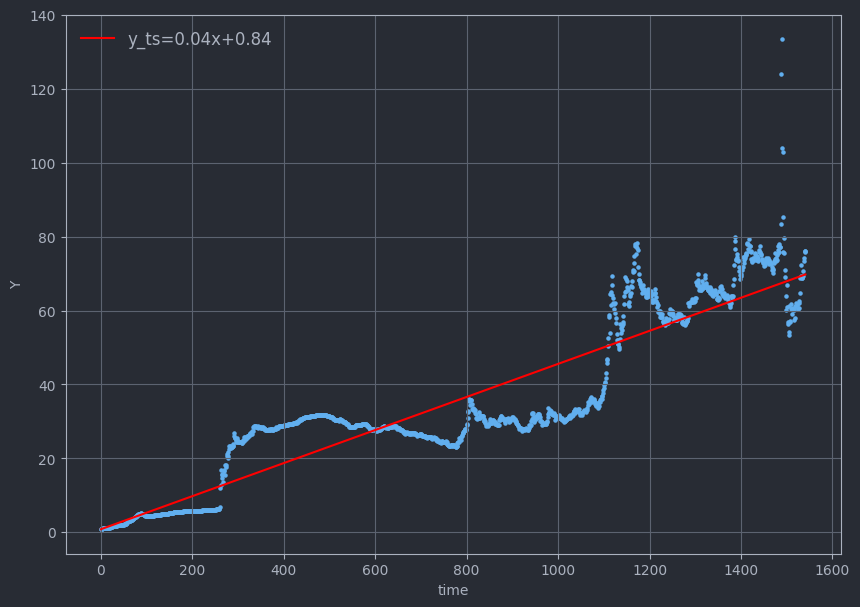

torch.Size([1542])


<ipython-input-111-bb59d44f4ea5>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_nontrend = y_ts-line


In [113]:
y_data = torch.tensor(y_ts_data_np['target'].values)
y_data

slope, intercept = Detrending.line_fit(y_ts_data_np.index.values, y_data)
Detrending.plot(y_ts_data_np.index.values,y_data,slope, intercept)

y_data = Detrending.trend_off(y_ts_data_np.index.values,y_data)
#plt.plot(y_ts_data_np.index.values,y_data)

x_data = torch.tensor(y_ts_data_np.index.values)
print(y_data.size())

## Testing the DFA Method

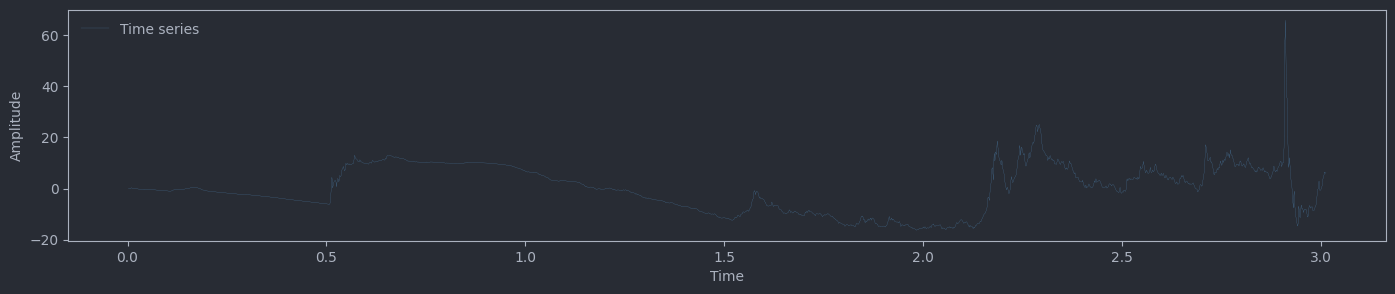

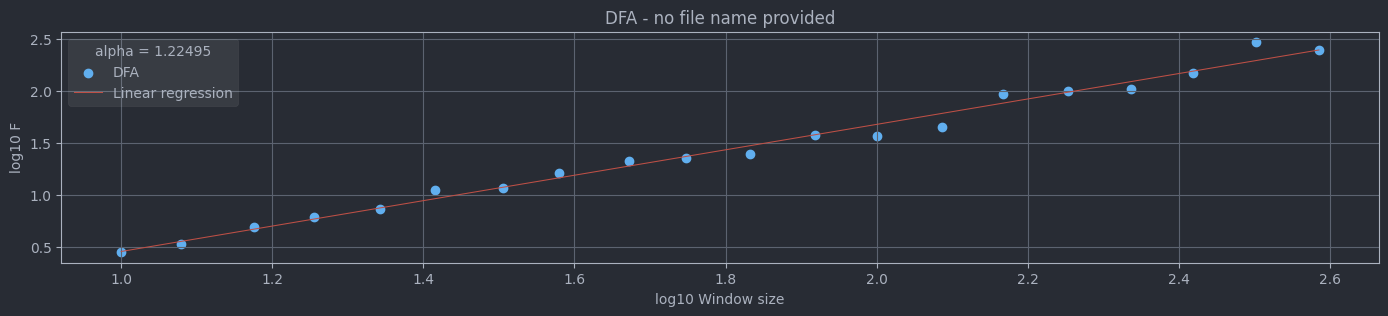

(np.float64(1.2249489455146183), np.float64(-0.7706537297527207))

In [114]:
DFA_F_Plot(x_data, y_data, window_size_step=20, plot_time_series=True)

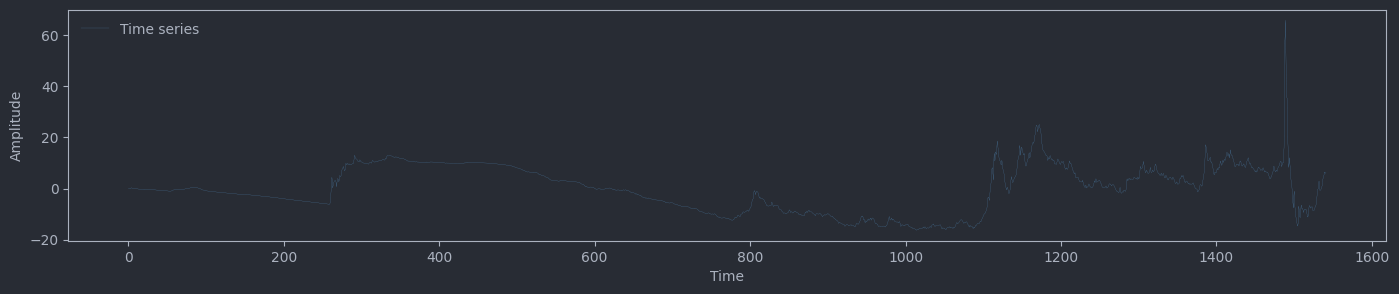

<Figure size 1542x300 with 0 Axes>

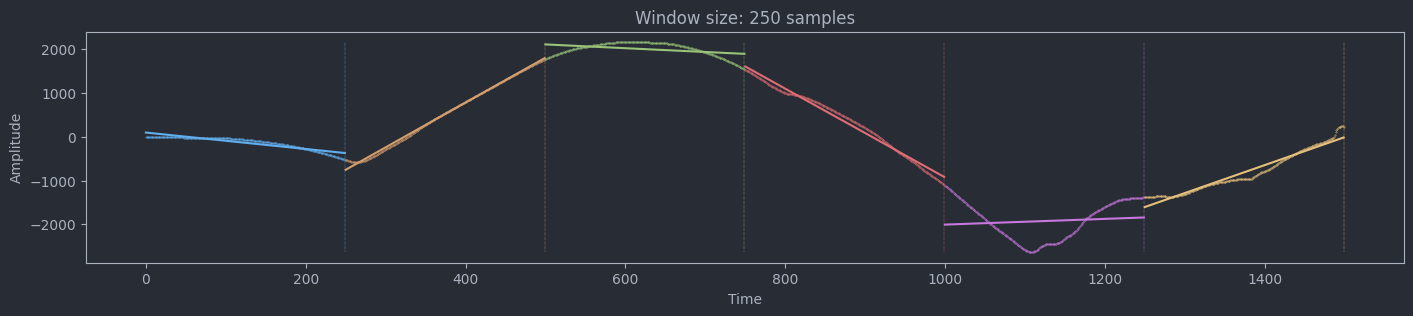

tensor(202.3599, dtype=torch.float64)

In [115]:
DFA_Method(x_data, y_data, 250, plot_epochs=True, plot_time_series=True)

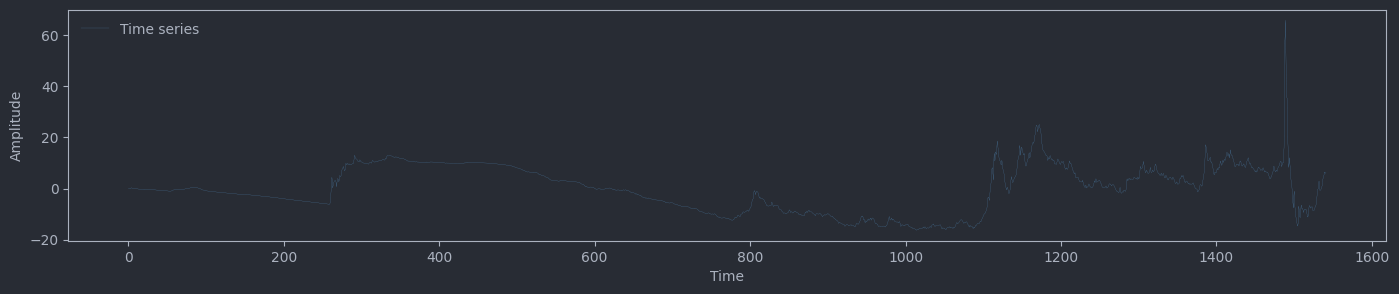

<Figure size 1542x300 with 0 Axes>

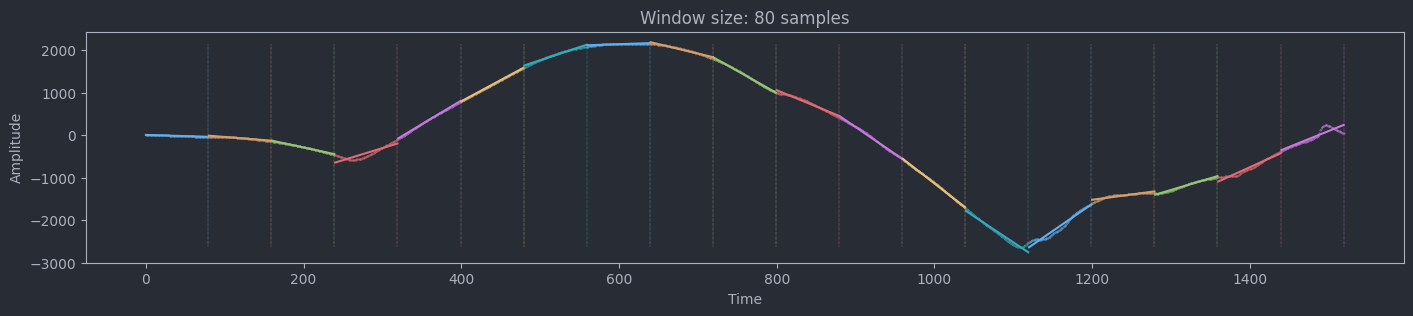

tensor(35.8690, dtype=torch.float64)

In [116]:
DFA_Method(x_data, y_data, 80, plot_epochs=True, plot_time_series=True)